In [14]:
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.objectives import binary_crossentropy
import matplotlib.pyplot as plt
from keras.utils import to_categorical

In [26]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# onehot encoding
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

intermediate_dim = 256
latent_dim = 2
batch_size = 100
nb_epoch = 20
noise_std = .01
n_pixels=28*28
cond=10
m = 50

In [27]:
x = Input(shape=(n_pixels,))
x_cond=Input(shape=(cond,))
inp=concat([x,x_cond],axis=1)
h = Dense(intermediate_dim, activation="relu")(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=0.01)
    return z_mean + K.exp(z_log_sigma) * epsilon
# what is the Lambda function 
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
z_conc=concat([z,x_cond],axis=1)
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(n_pixels, activation='sigmoid')
h_decoded = decoder_h(z_conc)
x_decoded_mean = decoder_mean(h_decoded)
cvae = Model([x,x_cond], x_decoded_mean) # <---new 

# encoder, from inputs to latent space
encoder = Model([x,x_cond], z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim+cond,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)


In [28]:
def vae_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

cvae.compile(optimizer='rmsprop', loss=vae_loss)
cvae.fit([x_train,Y_train], x_train,
        shuffle=True,
        epochs=nb_epoch,
        batch_size=batch_size,
        validation_data=([x_test,Y_test], x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 8s - loss: 0.2522 - val_loss: 0.2096
Epoch 2/20
60000/60000 [==============================] - 10s - loss: 0.2078 - val_loss: 0.2008
Epoch 3/20
60000/60000 [==============================] - 11s - loss: 0.1951 - val_loss: 0.1902
Epoch 4/20
60000/60000 [==============================] - 12s - loss: 0.1891 - val_loss: 0.1864
Epoch 5/20
60000/60000 [==============================] - 12s - loss: 0.1850 - val_loss: 0.1824
Epoch 6/20
60000/60000 [==============================] - 12s - loss: 0.1816 - val_loss: 0.1797
Epoch 7/20
60000/60000 [==============================] - 13s - loss: 0.1791 - val_loss: 0.1787
Epoch 8/20
60000/60000 [==============================] - 12s - loss: 0.1775 - val_loss: 0.1765
Epoch 9/20
60000/60000 [==============================] - 12s - loss: 0.1763 - val_loss: 0.1760
Epoch 10/20
60000/60000 [==============================] - 12s - loss: 0.1754 - val_los

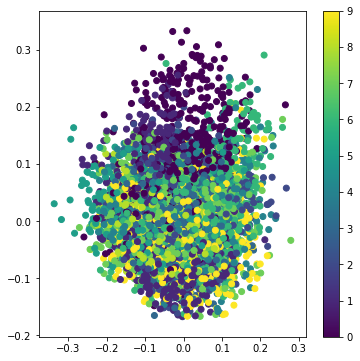

In [29]:
x_test_encoded = encoder.predict([x_test,Y_test], batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()



In [83]:
def construct_numvec(digit, z = None):
    out = np.zeros((1,2 + 10,))
    out[:,digit + 2] = 1.
    if z is None:
        return(out)
    else:
        for i in range(z.shape[1]):
            out[:,i] = z[0,i]
        return(out)
    
sample_3 = construct_numvec(3,np.array([[1,1]]))
print(sample_3)
print(sample_3.shape)
x_decoded = generator.predict(sample_3)
print(x_decoded.shape)

[[ 1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]]
(1, 12)
(1, 784)


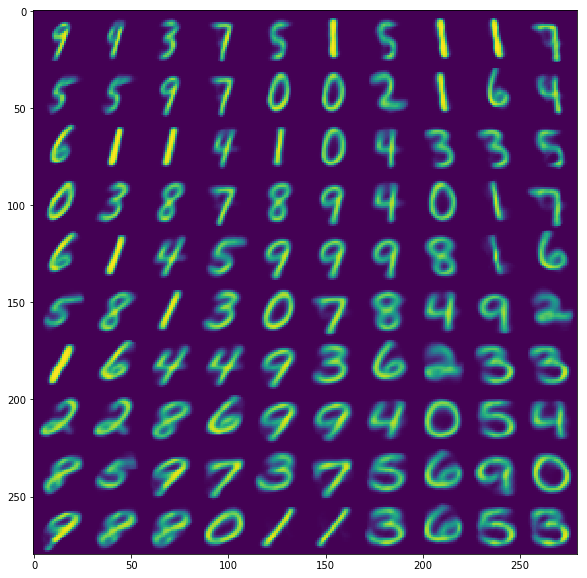

In [89]:
n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
num=0;
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        
        z_sample = np.array([[xi, yi]])* 0.01
        sample_3 = construct_numvec(np.random.choice(10, 1),z_sample)
        #print(sample_3)
        #x_decoded = generator.predict(sample_3)
       
        #x_decoded = generator.predict([[0.,0.],[0.  0.  0.  1.  0.  0.  0.  0.  0.  0.0]])
        x_decoded=_x_decoded_mean.eval({decoder_input:sample_3.astype('float32')})
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
    
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [85]:
#sample_3 = construct_numvec(num,z_sample)
print(sample_3)

[[ 0.15        0.04285714  0.          0.          0.          0.          0.
   0.          0.          0.          0.          1.        ]]


In [49]:
for i in range(len(z_sample)):
        out[:,i] = z_sample[1,i]
        print(out)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [96]:
decoder_input.eval({[x,x_cond]:np.hstack([x_test,Y_test]).astype('float32')})

TypeError: unhashable type: 'list'

In [97]:
x_test_encoded = encoder.predict([x_test,Y_test], batch_size=batch_size)

In [98]:
x_test_encoded[1]

array([ 0.03252168, -0.02473065], dtype=float32)